<a href="https://colab.research.google.com/github/Mahi200728/DataScience-A2/blob/main/JaviMaheU8Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Project: Breast Cancer Dataset

For this project I decided to do the predictability of Brest cancer through a multitude of variables. The ones I looked at for thus project were clump thickness, uniformity of cell size and shape, marginal adhesion, single epithelial cell size, bare nuclei, bland chromatin, normal nucleoli, and mitosis. A quick rundown of what each of those variables represent: Class is seperated into 2s and 4s in this project where 2 means non cancerous and 4 means cancerous. Clump thickness is measured by the thickness of the tumourous cells in a biopsy. This can help predict the class of cancer because typically the cancerous tumors form thicker and denser clumps. The unifomity of shape and size measures how similar the cells are in size and shape. This matters because most cancerous tumors have cells that vary in shapes and sizes which is unlike normal cells that are uniform in size and shape. Marginal adhesion is how well cells stick to eachother and it matters because cancerious cells typically are very loose and can spread easily. Single Epithelial cell size is essentally the size of the individual epithelial cells (those are the cells that like the exterior of our organs). This matters because abnomrally large epithelial cells are a sign of cancer. Bare nuclei is whether the nuclei is visible (doesn't have the surrounding cytoplasm) and a high count of those typically is an indicator of cancer. Normal nucleoli is how the nucleoli looks, if it looks too big it can mean that the cells are rapidly dividing (that leads to a tumor). Finally Mitosis measures the number of cells are dividing and it matters because a high rate means that the cells are dividing and replicating too fast and can cause cancer. These are the main variables that can be used to see if something is cancerous and studying these is vital in cancer research as a failure to catch it early can lead to a higher stage of cancer and other complications.

In [ ]:
!pip install pymc-bart
!pip install preliz

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import preliz as pz
import seaborn as sns

In [ ]:
from sklearn import tree

In [ ]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/Mahi200728/DataScience-A2/refs/heads/main/breast-cancer.csv"
cancer = pd.read_csv(url).dropna()
cancer = cancer.replace('?', np.nan)
# Drop rows with NaN values
cancer = cancer.dropna()

In [ ]:
cancer

In [ ]:
X = cancer[['Clump_thickness',
            'Uniformity_of_cell_size',
            'Uniformity_of_cell_shape',
            'Marginal_adhesion',
            'Single_epithelial_cell_size',
            'Bare_nuclei',
            'Bland_chromatin',
            'Normal_nucleoli',
            'Mitoses',
]]
Y = cancer['Class'].replace({2: 0, 4: 1}).to_numpy()

In [ ]:
for col in X.columns:
  X[col] = X[col].astype(int)
X

To start off I just wanted to visualize the data so i made scatterplots.

<Axes: xlabel='Uniformity_of_cell_size', ylabel='Class'>

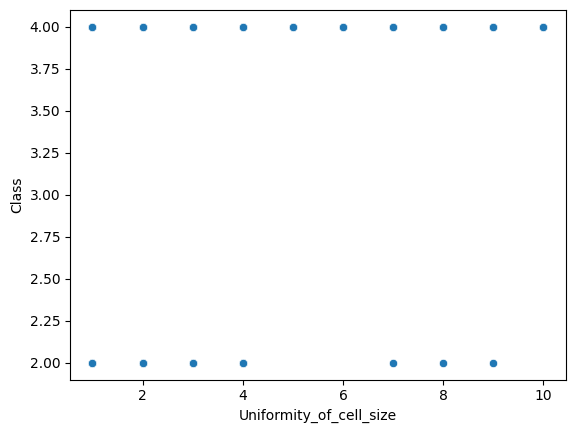

In [ ]:
sns.scatterplot(data = cancer, y = 'Class', x = 'Uniformity_of_cell_size')

<Axes: xlabel='Uniformity_of_cell_shape', ylabel='Class'>

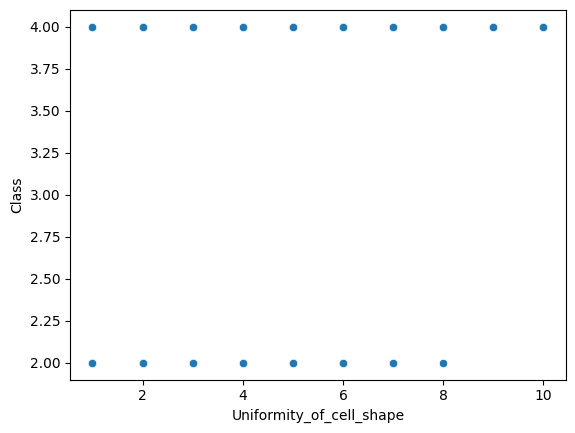

In [ ]:
sns.scatterplot(data = cancer, y = 'Class', x = 'Uniformity_of_cell_shape')

<Axes: xlabel='Marginal_adhesion', ylabel='Class'>

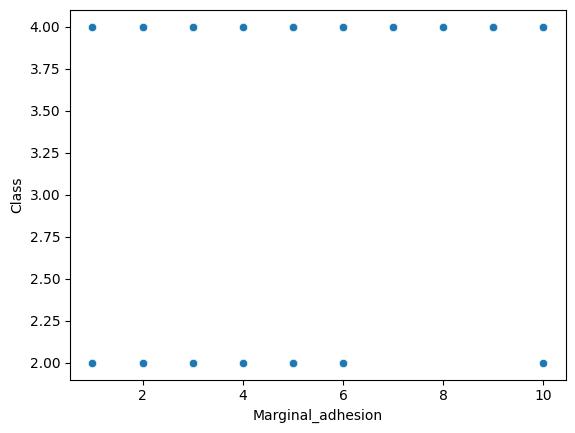

In [ ]:
sns.scatterplot(data = cancer, y = 'Class', x = 'Marginal_adhesion')

<Axes: xlabel='Single_epithelial_cell_size', ylabel='Class'>

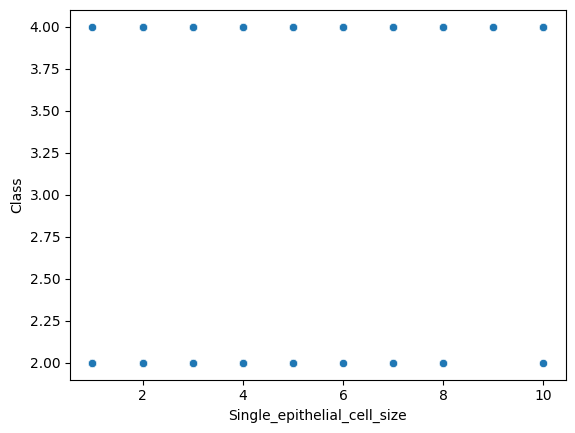

In [ ]:
sns.scatterplot(data = cancer, y = 'Class', x = 'Single_epithelial_cell_size')

These scatterplots showed a trend towards class 4 which means that they are probably indicators of cancer. This reflects the information we knew from above about each variable and its affects on whether something is cancerous or not. That being said there is a lot overlap between class 2 and class 4 for these variables which means that these variables can't be sole predictors of whetehr something is cancerous or not. The uniformaity of size and shape showed a correlation between uniformaity and cancerous, the more uniform the cells were the less likely they were ti be cancerous (class 2) while the less uniform they were the more likely they were to being classifed as class 4. The marginal adhesion showed a similar trend where higher adhesion values correlated with a higher likelihood of malignancy. Finally the single epithelial cell size showed that largder cells were more common with class 4 than class 2s.

In [ ]:
with pm.Model() as model_cancerR:
    μ_ = pmb.BART("μ_", X, Y, m=50)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ_))
    y = pm.Bernoulli("y", p=θ, observed=Y)
    idata_cancerR = pm.sample()

Output()

<Axes: xlabel='y'>

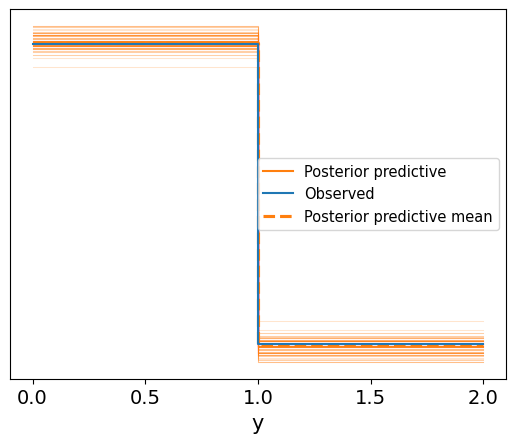

In [ ]:
pm.sample_posterior_predictive(idata_cancerR,model_cancerR, extend_inferencedata=True)
az.plot_ppc(idata_cancerR, num_pp_samples=100, colors=["C1", "C0", "C1"])

I combined bernoulli with BART because class is binary. When we ran the bart with all the variables the observed fit almost perfectly within the posterior predictive mean and the posterior predictive. This is amazing and the clear drop at 1 shows that the model is confident that the data is following this trend and there is a difference between 0 and 1. The spread of the data was very compact which also helps us know that the model isn't really uncertain and it can be gneralized decently well. But that being said I was wondering how much the data was muddled by the obscure number of variables so to just test I decided to do the same but just with uniformaty of cell size and shape.

In [ ]:
X = cancer[['Uniformity_of_cell_size',
           'Uniformity_of_cell_shape',
]]
Y = cancer['Class'].replace({2: 0, 4: 1}).to_numpy()

In [ ]:
with pm.Model() as model_cancer:
    μ_ = pmb.BART("μ_", X, Y, m=50)
    θ = pm.Deterministic("θ", pm.math.sigmoid(μ_))
    y = pm.Bernoulli("y", p=θ, observed=Y)
    idata_cancer = pm.sample()

Output()

<Axes: xlabel='y'>

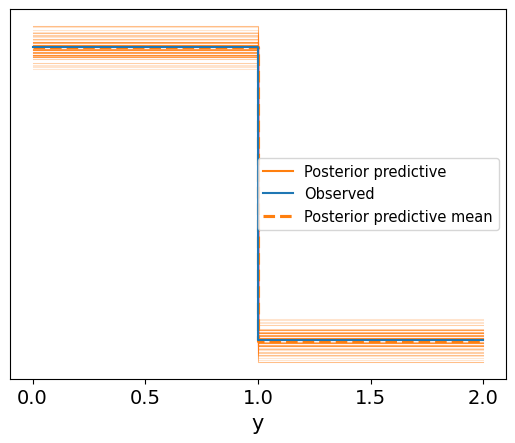

In [ ]:
pm.sample_posterior_predictive(idata_cancer,model_cancer, extend_inferencedata=True)
az.plot_ppc(idata_cancer, num_pp_samples=100, colors=["C1", "C0", "C1"])

When I did this it gave me basically the same graph, the only miniscule differnece being that the posterior preductive aroudn 0 and 2 was a little more wide meaning it was a bit less certain but it basically was identical. This means that the first model is a great preditor and the number of variables doesn't really affect the output.

In [ ]:
posterior_mean = idata_cancerR.posterior["μ_"]

μ_hdi = az.hdi(ary=idata_cancerR, group="posterior", var_names=["μ_"], hdi_prob=0.74)

pps = az.extract(
    idata_cancerR, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


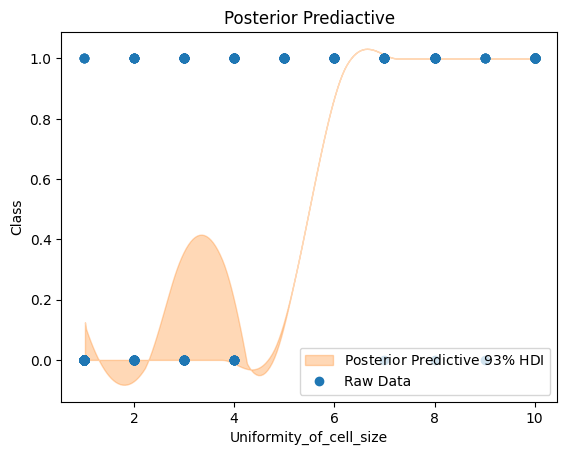

In [ ]:
idx = np.argsort(X.iloc[:, 0].to_numpy()) # convert the pandas series to a numpy array for indexing
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.iloc[:, 0].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)


ax.plot(cancer["Uniformity_of_cell_size"], Y, "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Prediactive",
    xlabel="Uniformity_of_cell_size",
    ylabel="Class",
);

In [ ]:
posterior_mean = idata_cancerR.posterior["μ_"]

μ_hdi = az.hdi(ary=idata_cancerR, group="posterior", var_names=["μ_"], hdi_prob=0.74)

pps = az.extract(
    idata_cancerR, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


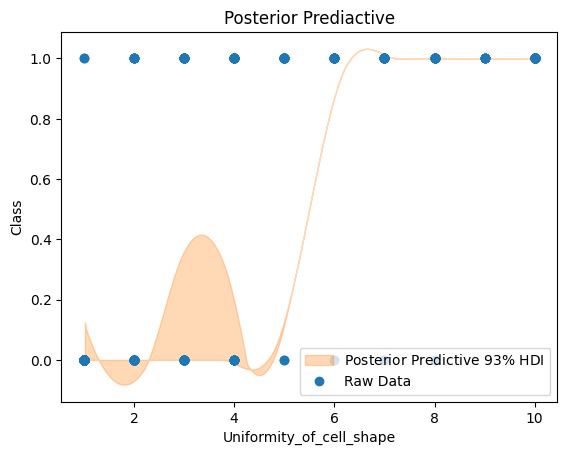

In [ ]:
idx = np.argsort(X.iloc[:, 0].to_numpy()) # convert the pandas series to a numpy array for indexing
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.iloc[:, 0].to_numpy(), # convert the pandas series to a numpy array for indexing
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior Predictive $93\%$ HDI"},
)


ax.plot(cancer["Uniformity_of_cell_shape"], Y, "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Prediactive",
    xlabel="Uniformity_of_cell_shape",
    ylabel="Class",
);

I then decided to do a posterior predictive plot for uniformaity of cell shape and size, and because the two graphs are essentially identically imma analyze them together. These graphs can be broken into low uniformaity, transition, and high uniformatity. The low is between 1 and 4 on the x axis and in both graphs it confiently predicts non cancerous cells. This makes sense because most if not all tumors typically don't have uniform cells shapes or sizes as they replicate too quickly. So uniform cells are a sign of normal tissue and the model confidently predicts that. Then we see the sudden rise between 5 and 6 which shows us that this is the transition zone between cells be cancerious or not and the graph going up that quickly means that there is a little bit of uncertanty within this bit where the cells could just be odd or they could be cancerous. When this is seen doctors typically call for biopsys and other imaging to double check whether the cells are cancerous or not. And finally between 7 and 10 there us a very high level of confidence in predicting cancerous cells which is seen by the very skinny 94% hdi. This means that cells that vary in size and shape are typically strong correlators of cancer.

array([<Axes: xlabel='Clump_thickness'>,
       <Axes: xlabel='Uniformity_of_cell_size'>,
       <Axes: xlabel='Uniformity_of_cell_shape'>,
       <Axes: xlabel='Marginal_adhesion'>,
       <Axes: xlabel='Single_epithelial_cell_size'>,
       <Axes: xlabel='Bare_nuclei'>, <Axes: xlabel='Bland_chromatin'>,
       <Axes: xlabel='Normal_nucleoli'>, <Axes: xlabel='Mitoses'>],
      dtype=object)

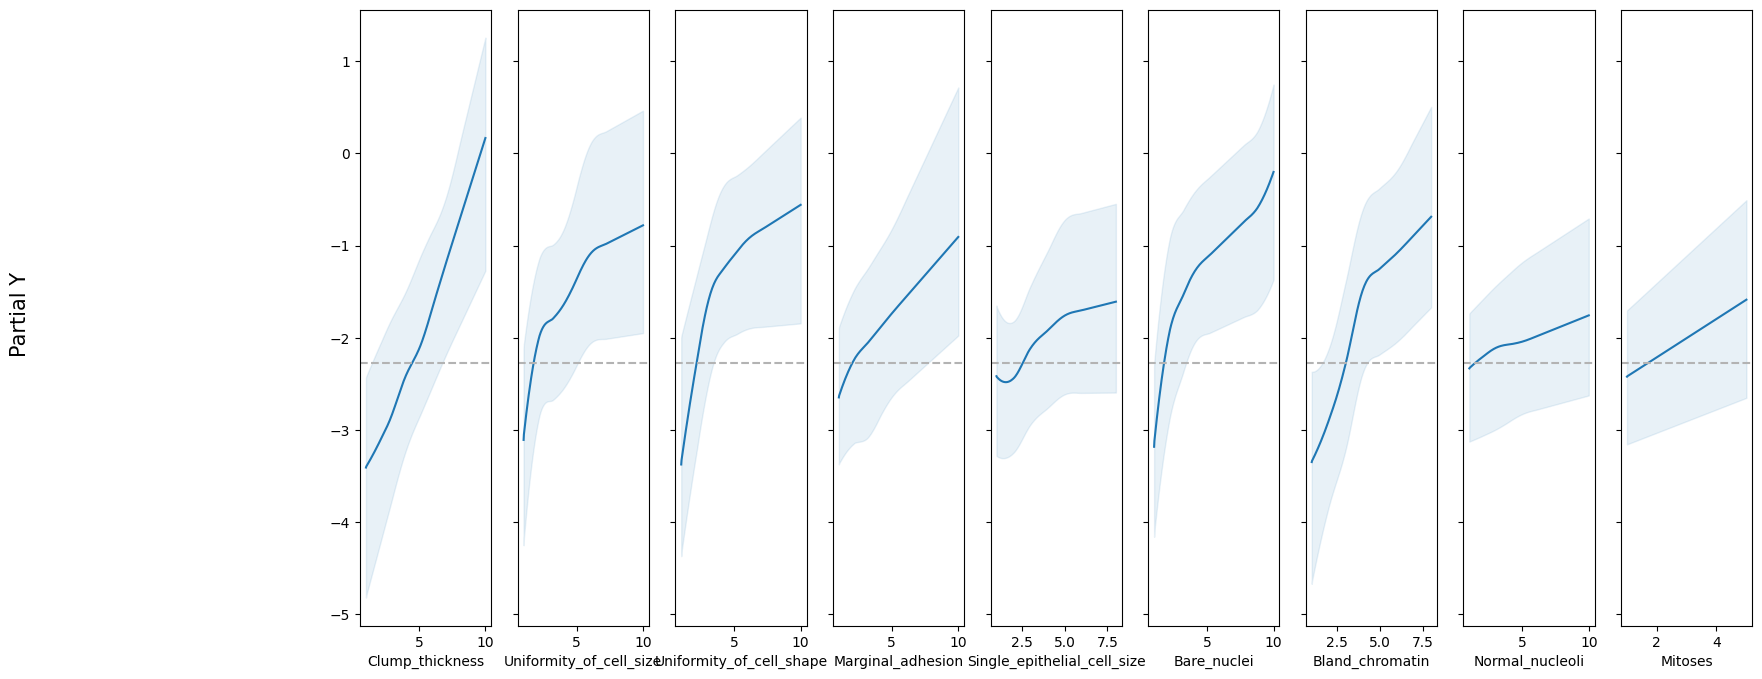

In [ ]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 10), figsize = (20, 8))

array([<Axes: xlabel='Clump_thickness'>,
       <Axes: xlabel='Uniformity_of_cell_size'>,
       <Axes: xlabel='Uniformity_of_cell_shape'>,
       <Axes: xlabel='Marginal_adhesion'>,
       <Axes: xlabel='Single_epithelial_cell_size'>,
       <Axes: xlabel='Bare_nuclei'>, <Axes: xlabel='Bland_chromatin'>,
       <Axes: xlabel='Normal_nucleoli'>, <Axes: xlabel='Mitoses'>],
      dtype=object)

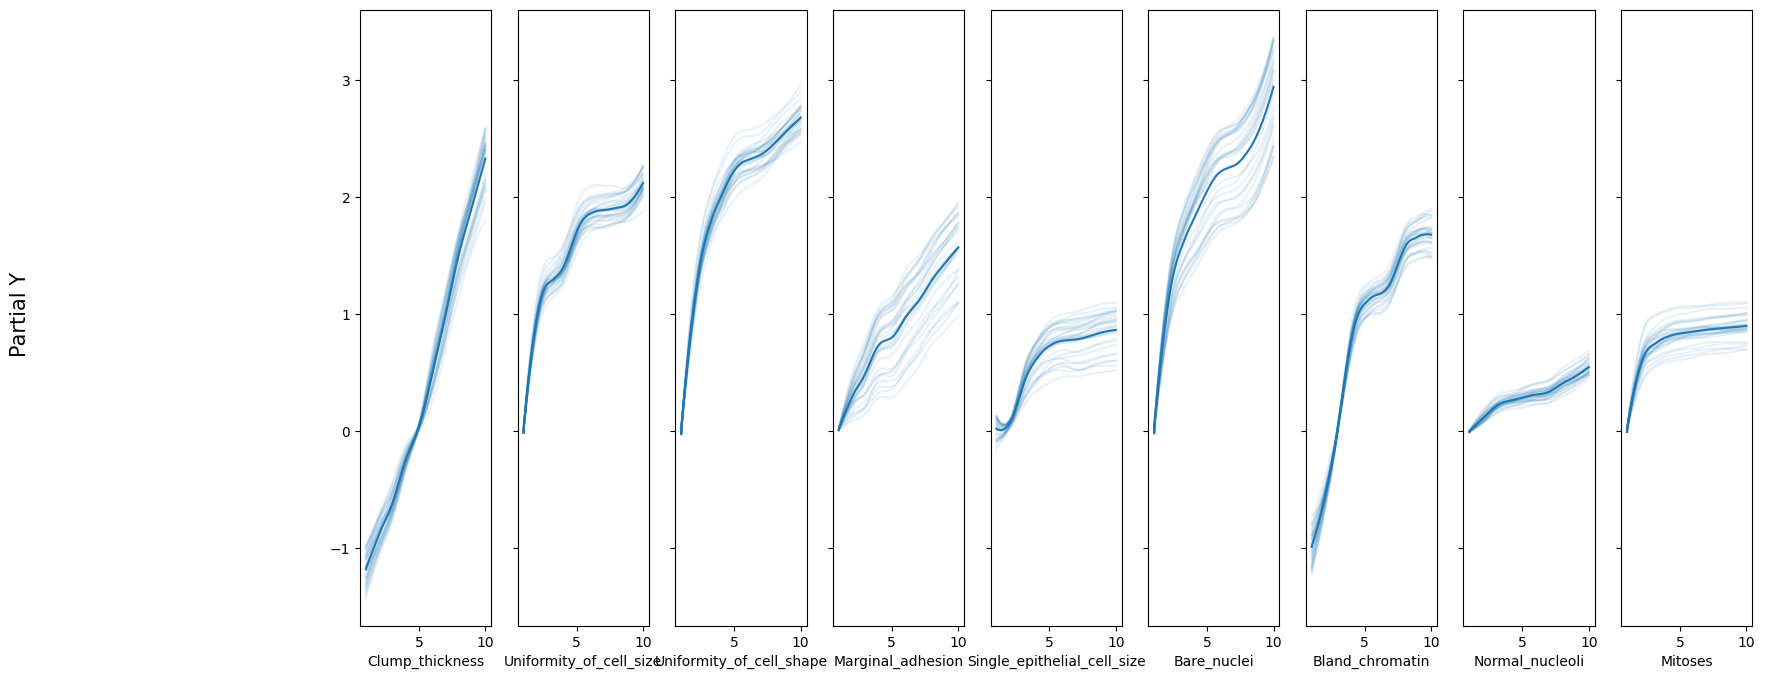

In [ ]:
pmb.plot_ice( μ_, X, Y, grid=(1, 10), figsize = (20,8))

Again because the pdp and ice are so similar im just gonna analyze them together. The clump thickness is a super steep increase with not that much variation when looking at the ice plot whch means that as thickness increases the model is very likely to predict whether it is cancerous or not. This correlates with what I said at the beginning where thicker clumps typically is associated with uncontrolable growth (cancer). Then uniformaity of cell shape and size are pretty similar where they rapidly increase and then level out which means that cells that have many different sizes or shapes is a common factor in cancer and so can be used to help predict whether it is cancerous or not. The marginal adhesion and single epithelial cell size on the other hand increase less drastically with the single cell being very leveled off. This means that while they are good predictors they aren't the strongest. This might just be the case because these variables are harder to locate and study as it requires you to look inside the body instead of doing a biopsy (easier). Then the bare nuclei and bland chromatin are seen with strong correlations which

In [ ]:
vi_cancer = pmb.compute_variable_importance(idata_cancerR, μ_, X)

<Axes: ylabel='R²'>

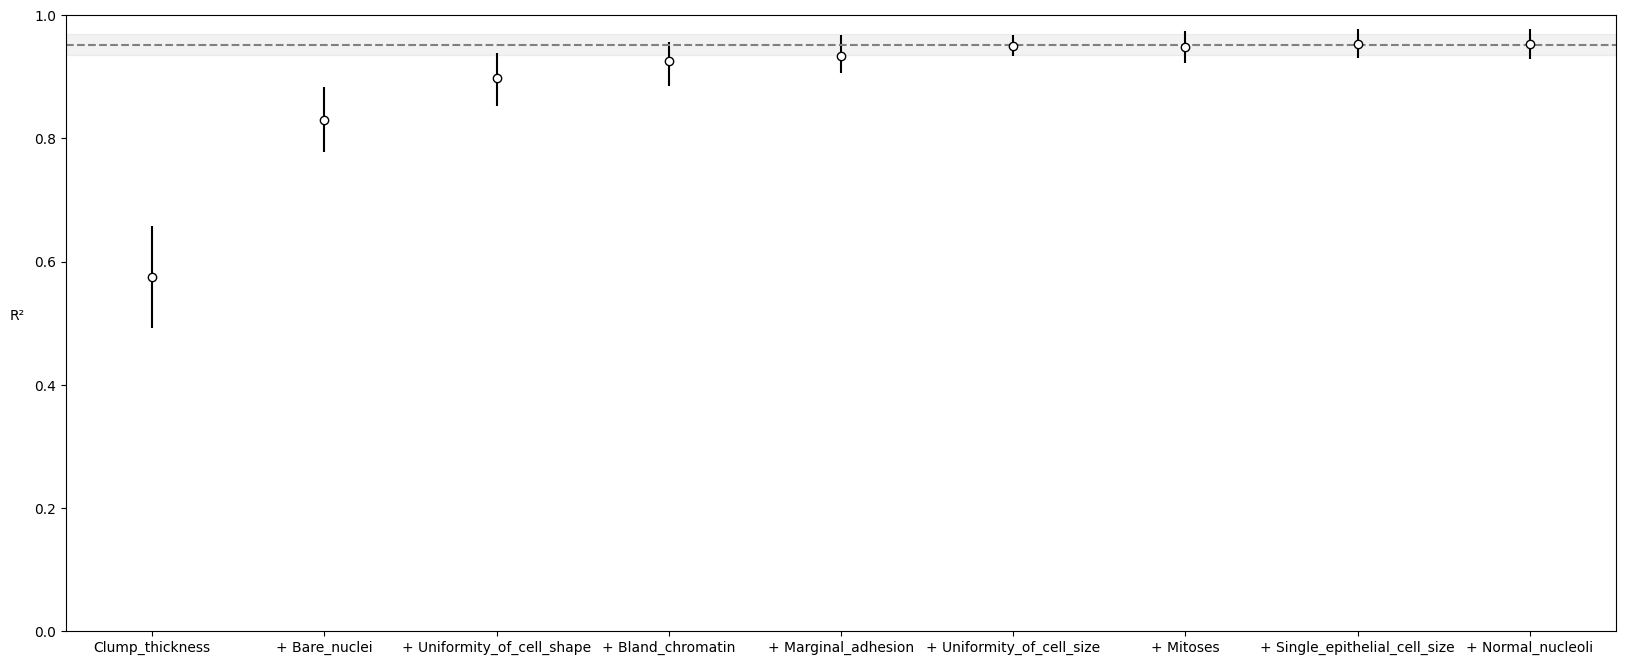

In [ ]:
pmb.plot_variable_importance(vi_cancer, figsize = (20,8))

The range of the clumpthickness, bare nuclei, and uniformaty of the cell shape was the biggest predictive variables. They all have very a direct correlation to cancer.